In [139]:
NOTEBOOK_NAME = "e018_add_space_first"

In [140]:
import numpy as np
import polars as pl
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib

In [141]:
train = pl.read_csv("../data/train.csv")
test = pl.read_csv("../data/test.csv")
era = pl.read_csv("../data/era_improve.csv")
sample_submission = pl.read_csv("../data/sample_submission.csv")

# 前処理

In [142]:
import re


def get_prefecture(text: str) -> str | None:
    all_prefectures = (
        "北海道|青森県|岩手県|宮城県|秋田県|山形県|福島県|"
        + "茨城県|栃木県|群馬県|埼玉県|千葉県|東京都|神奈川県|"
        + "新潟県|富山県|石川県|福井県|山梨県|長野県|岐阜県|静岡県|愛知県|"
        + "三重県|滋賀県|京都府|大阪府|兵庫県|奈良県|和歌山県|"
        + "鳥取県|島根県|岡山県|広島県|山口県|"
        + "徳島県|香川県|愛媛県|高知県|"
        + "福岡県|佐賀県|長崎県|熊本県|大分県|宮崎県|鹿児島県|沖縄県"
    )
    if match := re.search(all_prefectures, text):
        return match.group(0)
    else:
        return None


# 都道府県を抽出
train = train.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)
test = test.with_columns(
    pl.col("都道府県 ※美工品は「所有者住所（所在都道府県）」").apply(get_prefecture).alias("都道府県")
)

train = train.with_columns(pl.col("所在地").apply(get_prefecture).alias("所在地_都道府県"))
test = test.with_columns(pl.col("所在地").apply(get_prefecture).alias("所在地_都道府県"))

In [143]:
# 種別2より建造物か美工品かを分類する特徴を追加
kenzoubutu_feat = [
    "近世以前／神社",
    "近世以前／神社",
    "近世以前／寺院",
    "近世以前／城郭",
    "近世以前／住宅",
    "近世以前／民家",
    "近世以前／その他",
    "近代／宗教",
    "近代／学校",
    "近代／官公庁舎",
    "近代／産業・交通・土木",
    "近代／住居",
    "近代／文化施設",
    "近代／商業・業務",
    "近代／その他",
]

bikouhin_feat = ["宝", "絵画", "彫刻", "工芸品", "書跡・典籍", "古文書", "考古資料", "歴史資料"]


def classify_kenzoubutu_bikouhin(text: str | None) -> str | None:
    if text in kenzoubutu_feat:
        return "建造物"
    elif text in bikouhin_feat:
        return "美工品"
    return None


train = train.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)
test = test.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
)

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_23909/1010906722.py:32: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")
/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_23909/1010906722.py:35: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_bikouhin)
  + pl.col("種別2").is_in(kenzoubutu_feat) & '建造物' & '美工品'

  pl.col("種別2").apply(classify_kenzoubutu_bikouhin).alias("建造物_or_美工品")


In [144]:
def classify_kenzoubutu_genre(text: str | None) -> str | None:
    if text == "近世以前／神社":
        return "神社"
    elif text == "近世以前／寺院":
        return "寺院"
    elif text == "近世以前／城郭":
        return "城郭"
    elif text == "近世以前／住宅":
        return "住宅"
    elif text == "近世以前／民家":
        return "民家"
    elif text == "近世以前／その他":
        return "その他"
    elif text == "近代／宗教":
        return "宗教"
    elif text == "近代／学校":
        return "学校"
    elif text == "近代／官公庁舎":
        return "官公庁舎"
    elif text == "近代／産業・交通・土木":
        return "産業・交通・土木"
    elif text == "近代／住居":
        return "住居"
    elif text == "近代／文化施設":
        return "文化施設"
    elif text == "近代／商業・業務":
        return "商業・業務"
    elif text == "近代／その他":
        return "その他"  # ここはその他で被っている
    return None


train = train.with_columns(
    pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類")
)
test = test.with_columns(pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類"))

/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_23909/808284332.py:34: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_genre)
  + (pl.col("種別2") == '近世以前／神社') & '神社' & '寺院' & '城郭' & '住宅' & '民家' & 'その他' & '宗教' & '学校' & '官公庁舎' & '産業・交通・土木' & '住居' & '文化施設' & '商業・業務' & 'その他'

  pl.col("種別2").apply(classify_kenzoubutu_genre).alias("建造物_種類")
/var/folders/4p/kqrm_mh10fn2pjkrxfzxh03c0000gq/T/ipykernel_23909/808284332.py:36: PolarsInefficientApplyWarning: 
Expr.apply is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
In this case, you can replace your `apply` with the following:
  - pl.col("種別2").apply(classify_kenzoubutu_genre)
  + (pl.col("種別2") == '近世以前／神社') & '神社' & '寺院' & '城郭' & '住宅' & '

In [145]:
# 時代を取得する
import re


def get_era(text: str) -> str | None:
    all_era = [
        "鎌倉",
        "元",
        "古墳",
        "江戸",
        "高麗",
        "室町",
        "昭和",
        "大正",
        "唐",
        "桃山",
        "奈良",
        "縄文",
        "縄文",
        "南宋",
        "南北朝",
        "飛鳥",
        "平安",
        "北宋",
        "明治",
        "弥生",
        "明",
    ]
    for era in all_era:
        if era in text:
            return era
    return None


# 時代を抽出
train = train.with_columns(pl.col("時代").apply(get_era).alias("時代_抽出"))
test = test.with_columns(pl.col("時代").apply(get_era).alias("時代_抽出"))

In [146]:
def get_shoyusya_genre(text: str) -> str | None:
    words = [
        "神宮",
        "八幡宮",
        "神社",
        "株式会社",
        "有限会社",
        "研究機構",
        "独立行政法人",
        "公益財団法人",
        "財団法人",
        "学校法人",
        "大学",
        "県",
        "市",
        "区",
        "国",
        "寺",
    ]
    for word in words:
        if word in text:
            return word
    return None


train = train.with_columns(pl.col("所有者名").apply(get_shoyusya_genre).alias("所有者名_genre"))
test = test.with_columns(pl.col("所有者名").apply(get_shoyusya_genre).alias("所有者名_genre"))

In [147]:
era

時代,開始,終了
str,i64,i64
"""鎌倉""",1185,1333
"""平安""",794,1185
"""明治""",1868,1912
"""桃山""",1573,1603
"""江戸中期""",1603,1868
"""室町""",1336,1573
"""南北朝""",1337,1392
"""江戸前期""",1603,1868
"""江戸""",1603,1868


In [148]:
train.join(era, on="時代", how="left")

名称,棟名,種別2,国,時代,都道府県 ※美工品は「所有者住所（所在都道府県）」,所在地,保管施設の名称,所有者名,管理団体又は責任者,緯度,経度,is_kokuhou,都道府県,所在地_都道府県,建造物_or_美工品,建造物_種類,時代_抽出,所有者名_genre,開始,終了
str,str,str,str,str,str,str,str,str,str,f64,f64,i64,str,str,str,str,str,str,i64,i64
"""泉布観""",null,"""近代／文化施設""",null,"""明治""","""大阪府""","""大阪府大阪市北区天満橋一丁目…",null,"""大阪市""",null,34.69811,135.5214,0,"""大阪府""","""大阪府""","""建造物""","""文化施設""","""明治""","""市""",1868,1912
"""絹本著色准胝仏母像""",null,"""絵画""","""日本""","""鎌倉""","""京都府（京都府）""",null,null,"""広隆寺""",null,null,null,0,"""京都府""",null,"""美工品""",null,"""鎌倉""","""寺""",1185,1333
"""石上神宮拝殿""",null,"""近世以前／寺院""",null,"""鎌倉前期""","""奈良県""","""奈良県天理市布留町""",null,"""石上神宮""",null,34.5978,135.852,1,"""奈良県""","""奈良県""","""建造物""","""寺院""","""鎌倉""","""神宮""",1185,1333
"""剣〈銘真守（備前）／〉""",null,"""工芸品""","""日本""","""鎌倉""","""和歌山県（和歌山県）""",null,null,"""宗教法人金剛峯寺""","""財団法人高野山文化財保存会""",null,null,0,"""和歌山県""",null,"""美工品""",null,"""鎌倉""","""寺""",1185,1333
"""旧新町紡績所""","""工場本館""","""近代／産業・交通・土木""",null,"""明治""","""群馬県""","""群馬県高崎市新町二三三〇番地…",null,"""クラシエフーズ株式会社""",null,36.27766,139.1003,0,"""群馬県""","""群馬県""","""建造物""","""産業・交通・土木""","""明治""","""株式会社""",1868,1912
"""刀〈無銘正宗（名物石田正宗）…",null,"""工芸品""","""日本""","""鎌倉""","""東京都（東京都）""","""東京国立博物館 東京都台東区…","""東京国立博物館""","""独立行政法人国立文化財機構""",null,35.719944,139.775637,0,"""東京都""","""東京都""","""美工品""",null,"""鎌倉""","""独立行政法人""",1185,1333
"""刀〈無銘伝備中依真／〉""",null,"""工芸品""","""日本""","""南北朝""","""（福井県）""","""福井市文京3-16-1""","""福井県立美術館""",null,null,36.0786,136.2152,0,"""福井県""",null,"""美工品""",null,"""南北朝""",null,1337,1392
"""姫路城""","""リの一渡櫓""","""近世以前／城郭""",null,"""桃山""","""兵庫県""","""兵庫県姫路市本町""",null,"""国(文部科学省)""","""姫路市""",34.83876,134.6933,0,"""兵庫県""","""兵庫県""","""建造物""","""城郭""","""桃山""","""国""",1573,1603
"""絹本墨画生々流転図〈横山大観…",null,"""絵画""","""日本""","""大正""","""東京都（東京都）""","""東京国立近代美術館 東京都千…","""東京国立近代美術館""","""独立行政法人国立美術館""",null,35.690568,139.754725,0,"""東京都""","""東京都""","""美工品""",null,"""大正""","""独立行政法人""",1912,1926


In [149]:
# 抽出した時代と、era.csvを紐づける
# train = train.join(era, left_on="時代_抽出", right_on="時代", how="left")
# test = test.join(era, left_on="時代_抽出", right_on="時代", how="left")

train = train.join(era, on="時代", how="left")
test = test.join(era, on="時代", how="left")

# 開始 -終了の期間を計算する
train = train.with_columns((pl.col("終了") - pl.col("開始")).alias("時代_期間"))
test = test.with_columns((pl.col("終了") - pl.col("開始")).alias("時代_期間"))

In [150]:
# 緯度と経度のブロックを追加する
def classify_coordinates_japan(lat: float, lon: float) -> str | None:
    if lat is None or lon is None:
        return None

    lat_block = int((lat - 24) // (22 / 50))
    lon_block = int((lon - 123) // (30 / 50))

    return f"{lat_block}_{lon_block}"


train_outputs = []
for i, j in zip(train["緯度"], train["経度"]):
    train_outputs.append(classify_coordinates_japan(i, j))

train = train.with_columns(pl.Series(train_outputs).alias("緯度_経度_ブロック"))

test_outputs = []
for i, j in zip(test["緯度"], test["経度"]):
    test_outputs.append(classify_coordinates_japan(i, j))

test = test.with_columns(pl.Series(test_outputs).alias("緯度_経度_ブロック"))

In [151]:
from unicodedata import normalize


def get_prefecture_city(text: str | None) -> str | None:
    if text is None:
        return None
    text = normalize("NFKC", text)
    address_pattern = r"([一-龠]{1,3}[都道府県])([一-龠]{1,3}[市区町村])"

    if match := re.search(address_pattern, text):
        return match.group(1) + match.group(2)
    return None


train = train.with_columns(
    pl.col("所在地").apply(get_prefecture_city).alias("所在地_pref_city")
)
test = test.with_columns(
    pl.col("所在地").apply(get_prefecture_city).alias("所在地_pref_city")
)

In [152]:
def get_shozaiti_first(text: str | None) -> str | None:
    if text is None:
        return None
    text = normalize("NFKC", text)
    if " " in text:
        return text.split(" ")[0]
    return None


train = train.with_columns(pl.col("所在地").apply(get_shozaiti_first).alias("所在地_first"))
test = test.with_columns(pl.col("所在地").apply(get_shozaiti_first).alias("所在地_first"))

# データ型の変更

In [153]:
categorical_cols = [
    "棟名",
    "種別2",
    "国",
    "都道府県 ※美工品は「所有者住所（所在都道府県）」",
    "時代",
    "保管施設の名称",
    "所有者名",
    "管理団体又は責任者",
    "都道府県",
    "所在地",
    "所在地_都道府県",
    "建造物_or_美工品",
    "建造物_種類",
    "時代_抽出",
    "所有者名_genre",
    "緯度_経度_ブロック",
    "所在地_pref_city",
    "所在地_first",
]

In [154]:
# カウントエンコーディングを行う
merge_df = pl.concat([train[categorical_cols], test[categorical_cols]])

In [155]:
merge_df

棟名,種別2,国,都道府県 ※美工品は「所有者住所（所在都道府県）」,時代,保管施設の名称,所有者名,管理団体又は責任者,都道府県,所在地,所在地_都道府県,建造物_or_美工品,建造物_種類,時代_抽出,所有者名_genre,緯度_経度_ブロック,所在地_pref_city,所在地_first
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
null,"""近代／文化施設""",null,"""大阪府""","""明治""",null,"""大阪市""",null,"""大阪府""","""大阪府大阪市北区天満橋一丁目…","""大阪府""","""建造物""","""文化施設""","""明治""","""市""","""24_20""","""大阪府大阪市""",null
null,"""絵画""","""日本""","""京都府（京都府）""","""鎌倉""",null,"""広隆寺""",null,"""京都府""",null,null,"""美工品""",null,"""鎌倉""","""寺""",null,null,null
null,"""近世以前／寺院""",null,"""奈良県""","""鎌倉前期""",null,"""石上神宮""",null,"""奈良県""","""奈良県天理市布留町""","""奈良県""","""建造物""","""寺院""","""鎌倉""","""神宮""","""24_21""","""奈良県天理市""",null
null,"""工芸品""","""日本""","""和歌山県（和歌山県）""","""鎌倉""",null,"""宗教法人金剛峯寺""","""財団法人高野山文化財保存会""","""和歌山県""",null,null,"""美工品""",null,"""鎌倉""","""寺""",null,null,null
"""工場本館""","""近代／産業・交通・土木""",null,"""群馬県""","""明治""",null,"""クラシエフーズ株式会社""",null,"""群馬県""","""群馬県高崎市新町二三三〇番地…","""群馬県""","""建造物""","""産業・交通・土木""","""明治""","""株式会社""","""27_26""","""群馬県高崎市""",null
null,"""工芸品""","""日本""","""東京都（東京都）""","""鎌倉""","""東京国立博物館""","""独立行政法人国立文化財機構""",null,"""東京都""","""東京国立博物館 東京都台東区…","""東京都""","""美工品""",null,"""鎌倉""","""独立行政法人""","""26_27""","""東京都台東区""","""東京国立博物館"""
null,"""工芸品""","""日本""","""（福井県）""","""南北朝""","""福井県立美術館""",null,null,"""福井県""","""福井市文京3-16-1""",null,"""美工品""",null,"""南北朝""",null,"""27_22""",null,null
"""リの一渡櫓""","""近世以前／城郭""",null,"""兵庫県""","""桃山""",null,"""国(文部科学省)""","""姫路市""","""兵庫県""","""兵庫県姫路市本町""","""兵庫県""","""建造物""","""城郭""","""桃山""","""国""","""24_19""","""兵庫県姫路市""",null
null,"""絵画""","""日本""","""東京都（東京都）""","""大正""","""東京国立近代美術館""","""独立行政法人国立美術館""",null,"""東京都""","""東京国立近代美術館 東京都千…","""東京都""","""美工品""",null,"""大正""","""独立行政法人""","""26_27""","""東京都千代田区""","""東京国立近代美術館"""


In [156]:
merge_count_df = merge_df.select(
    [pl.count().over(col).alias(f"{col}_count") for col in categorical_cols]
)

train_count_df = merge_count_df.slice(0, train.shape[0])
test_count_df = merge_count_df.slice(train.shape[0])

In [157]:
train = pl.concat([train, train_count_df], how="horizontal")
test = pl.concat([test, test_count_df], how="horizontal")

In [158]:
train.shape[0]

6710

In [159]:
# Trainにしかないデータを削除する
def only_train_is_null(train: pl.DataFrame, test: pl.DataFrame, col: str):
    only_train = set(train.get_column(col).unique())
    only_test = set(test.get_column(col).unique())

    share_value = only_train & only_test

    return train.with_columns(
        pl.when(pl.col(col).is_in(list(share_value)))
        .then(pl.col(col))
        .otherwise(None)
        .alias(col)
    )


for col in categorical_cols:
    train = only_train_is_null(train, test, col)

In [160]:
for col in categorical_cols:
    train = train.with_columns(pl.col(col).cast(pl.Categorical).alias(col))
    test = test.with_columns(pl.col(col).cast(pl.Categorical).alias(col))

# Fold

In [161]:
FOLD_NUM = 10

In [162]:
empty = np.zeros(train.height)
fold = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=33)

for idx, (_, val_idx) in enumerate(fold.split(train, train.get_column("is_kokuhou"))):
    empty[val_idx] = idx

train = train.with_columns(pl.Series(empty).cast(pl.Int64).alias("fold"))

# LightGBM

In [163]:
use_col = []

base_col = ["緯度", "経度", "開始", "終了", "時代_期間"]

use_col += base_col
use_col += categorical_cols
use_col += [f"{col}_count" for col in categorical_cols]

len(use_col)

41

In [164]:
use_col

['緯度',
 '経度',
 '開始',
 '終了',
 '時代_期間',
 '棟名',
 '種別2',
 '国',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」',
 '時代',
 '保管施設の名称',
 '所有者名',
 '管理団体又は責任者',
 '都道府県',
 '所在地',
 '所在地_都道府県',
 '建造物_or_美工品',
 '建造物_種類',
 '時代_抽出',
 '所有者名_genre',
 '緯度_経度_ブロック',
 '所在地_pref_city',
 '所在地_first',
 '棟名_count',
 '種別2_count',
 '国_count',
 '都道府県 ※美工品は「所有者住所（所在都道府県）」_count',
 '時代_count',
 '保管施設の名称_count',
 '所有者名_count',
 '管理団体又は責任者_count',
 '都道府県_count',
 '所在地_count',
 '所在地_都道府県_count',
 '建造物_or_美工品_count',
 '建造物_種類_count',
 '時代_抽出_count',
 '所有者名_genre_count',
 '緯度_経度_ブロック_count',
 '所在地_pref_city_count',
 '所在地_first_count']

In [165]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {"objective": "binary", "metric": "auc", "verbosity": -1}

In [166]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # polarsをpandasに変換
    train_pd = train.to_pandas()

    # foldごとにtrainとvalidに分ける
    train_fold = train_pd[train_pd["fold"] != fold]
    valid_fold = train_pd[train_pd["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop("is_kokuhou", axis=1)
    X_valid = valid_fold.drop("is_kokuhou", axis=1)
    y_train = train_fold[["is_kokuhou"]]
    y_valid = valid_fold[["is_kokuhou"]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100)
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    calc_f1_score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {calc_f1_score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

Start fold 0
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	training's auc: 0.963763	valid_1's auc: 0.875105
fold 0 Score: 0.8751046698872786
Start fold 1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	training's auc: 0.936567	valid_1's auc: 0.820274
fold 1 Score: 0.8202737520128824
Start fold 2
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	training's auc: 0.977049	valid_1's auc: 0.828003
fold 2 Score: 0.8280032206119163
Start fold 3
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	training's auc: 0.993252	valid_1's auc: 0.80533
fold 3 Score: 0.8053301127214171
Start fold 4
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[345]	training's auc: 0.9932	valid_1's auc: 0.859501
fold 4 Score: 0.859500805152979
Start fold 5
Trai

In [167]:
oof_score = roc_auc_score(y_true=train.get_column("is_kokuhou"), y_score=oof)
oof_score

0.8024693084438306

In [168]:
from sklearn.metrics import f1_score

# 0.01 から 0.99 まで 0.01 刻みで閾値を変えて、F1 score を計算する
max_f1_score = 0

for thr in np.arange(0.01, 1, 0.01):
    calc_f1_score = f1_score(train.get_column("is_kokuhou"), (oof > thr).astype(int))
    print(f"thr: {thr}, f1_score: {calc_f1_score}")
    if max_f1_score < calc_f1_score:
        max_f1_score = calc_f1_score
        best_thr = thr

print(f"Optimized thr: {best_thr}, f1 score: {max_f1_score}")

thr: 0.01, f1_score: 0.21899273365071412
thr: 0.02, f1_score: 0.2419070041200706
thr: 0.03, f1_score: 0.27608461814270346
thr: 0.04, f1_score: 0.29946960424316604
thr: 0.05, f1_score: 0.3147071971390255
thr: 0.060000000000000005, f1_score: 0.3271844660194175
thr: 0.06999999999999999, f1_score: 0.3352185089974293
thr: 0.08, f1_score: 0.3405875952121872
thr: 0.09, f1_score: 0.340843443096476
thr: 0.09999999999999999, f1_score: 0.3427881713940857
thr: 0.11, f1_score: 0.34127979924717694
thr: 0.12, f1_score: 0.3411458333333334
thr: 0.13, f1_score: 0.3494880546075086
thr: 0.14, f1_score: 0.35191889934829834
thr: 0.15000000000000002, f1_score: 0.35481425322213805
thr: 0.16, f1_score: 0.36047430830039523
thr: 0.17, f1_score: 0.3657331136738056
thr: 0.18000000000000002, f1_score: 0.359626802374894
thr: 0.19, f1_score: 0.3569553805774278
thr: 0.2, f1_score: 0.35294117647058826
thr: 0.21000000000000002, f1_score: 0.35654596100278546
thr: 0.22, f1_score: 0.3549618320610687
thr: 0.23, f1_score: 0.

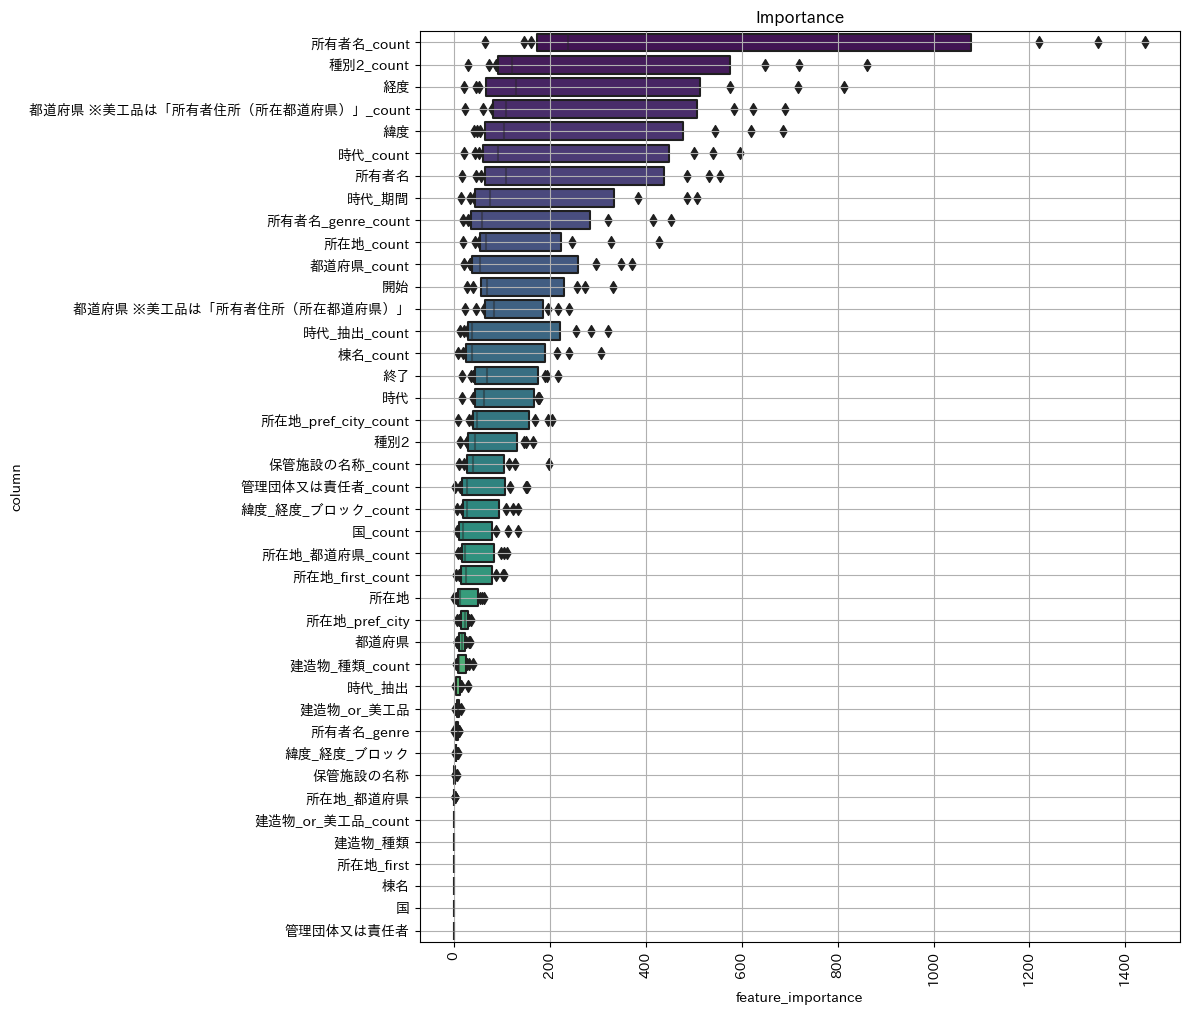

In [169]:
def visualize_importance(models: list, use_col: list) -> None:
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importance()
        _df["column"] = use_col
        _df["fold"] = i + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, _df], axis=0, ignore_index=True
        )

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax


fig, ax = visualize_importance(models, use_col)

In [170]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test.select(use_col).to_pandas()) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

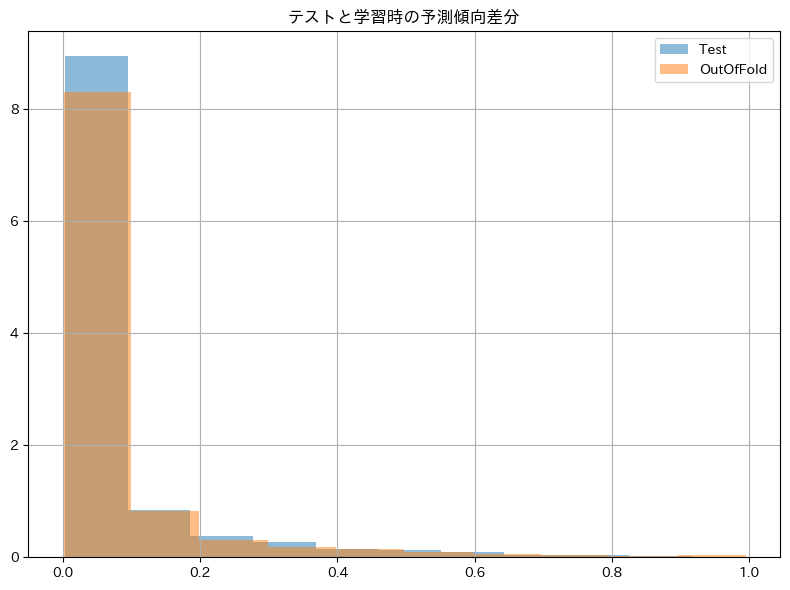

In [171]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [172]:
train.with_columns(pl.Series(oof).cast(pl.Float64).alias("oof")).write_csv(
    f"../oof/oof_{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)

In [173]:
sample_submission.with_columns(pl.Series("is_kokuhou", pred > best_thr).cast(int))

is_kokuhou
i64
0
0
1
0
0
0
0
0
0


In [174]:
sample_submission = sample_submission.with_columns(
    pl.Series("is_kokuhou", pred > best_thr).cast(int)
)
sample_submission

is_kokuhou
i64
0
0
1
0
0
0
0
0
0


In [175]:
sample_submission.write_csv(
    f"../sub/{NOTEBOOK_NAME}_f1score_{max_f1_score:.4f}_auc_{oof_score:.4f}.csv"
)